# Module 3: M/M/1 Model Validation
## Theoretical Predictions vs Real System Measurements

**Learning Objectives:**
- Estimate service rate from real system measurements
- Validate M/M/1 theoretical formulas against measured metrics
- Analyze model accuracy under varying load conditions
- Understand practical deviations from theoretical predictions

---

## Methodology

### Service Rate Estimation Strategy

Instead of estimating service rate from individual response times, we use a more robust approach:

1. **Calibration Campaign**: Run controlled experiment with known load
2. **Collect Metrics**: Measure utilization and throughput via Prometheus
3. **Calculate Service Rate**: μ = throughput / utilization
4. **Validation Experiments**: Test multiple load conditions using estimated μ

This approach provides more accurate service rate estimation by using steady-state system metrics rather than individual request timings.

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import time
import asyncio
from scipy import stats
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from workload_generator import AsyncWorkloadGenerator
from metrics_collector import PrometheusCollector, plot_mm1_validation_analysis, calculate_validation_statistics

# Set random seed for reproducibility
np.random.seed(42)

print("Module 3: M/M/1 Model Validation")
print("Modules imported successfully")
print("Ready for service rate calibration and validation experiments")

Module 3: M/M/1 Model Validation
Modules imported successfully
Ready for service rate calibration and validation experiments


In [4]:
class MM1Theoretical:
    """
    M/M/1 theoretical performance calculations with improved service rate estimation.
    """
    
    @staticmethod
    def calculate_metrics(lambda_rate: float, mu_rate: float) -> Dict[str, float]:
        """
        Calculate all M/M/1 theoretical metrics.
        
        Args:
            lambda_rate: Arrival rate (requests/second)
            mu_rate: Service rate (requests/second)
            
        Returns:
            Dictionary with theoretical metrics
        """
        if lambda_rate >= mu_rate:
            return {
                'utilization': float('inf'),
                'response_time': float('inf'),
                'system_size': float('inf'),
                'queue_length': float('inf'),
                'waiting_time': float('inf'),
                'stable': False
            }
        
        rho = lambda_rate / mu_rate
        
        return {
            'utilization': rho,
            'response_time': 1 / (mu_rate - lambda_rate),
            'system_size': rho / (1 - rho),
            'queue_length': (rho ** 2) / (1 - rho),
            'waiting_time': rho / (mu_rate * (1 - rho)),
            'throughput': lambda_rate,  # In stable system, throughput = arrival rate
            'stable': True
        }
    
    @staticmethod
    def estimate_service_rate_from_metrics(utilizations: List[float], throughputs: List[float]) -> Tuple[float, Dict]:
        """
        Estimate service rate from measured utilization and throughput metrics.
        
        Theory: utilization = λ/μ, so μ = λ/utilization ≈ throughput/utilization
        
        Args:
            utilizations: List of measured utilization values (0-1)
            throughputs: List of measured throughput values (req/s)
            
        Returns:
            Tuple of (estimated_mu, estimation_stats)
        """
        if not utilizations or not throughputs:
            return None, {'error': 'No data provided'}
            
        # Filter out invalid measurements
        valid_pairs = [(util, tp) for util, tp in zip(utilizations, throughputs) 
                      if util > 0.01 and tp > 0.01]  # Avoid division by very small numbers
        
        if len(valid_pairs) < 5:
            return None, {'error': f'Insufficient valid measurements: {len(valid_pairs)}'}
        
        # Calculate service rate for each measurement: μ = throughput / utilization
        service_rates = []
        for util, throughput in valid_pairs:
            mu = throughput / util
            service_rates.append(mu)
        
        # Calculate statistics
        estimated_mu = np.median(service_rates)
        mean_mu = np.mean(service_rates)
        std_mu = np.std(service_rates)
        cv_mu = std_mu / mean_mu if mean_mu > 0 else float('inf')
        
        estimation_stats = {
            'sample_size': len(service_rates),
            'median_mu': estimated_mu,
            'mean_mu': mean_mu,
            'std_mu': std_mu,
            'cv_mu': cv_mu,
            'min_mu': np.min(service_rates),
            'max_mu': np.max(service_rates),
            'valid_measurements': len(valid_pairs),
            'total_measurements': len(utilizations)
        }
        
        return estimated_mu, estimation_stats

print("M/M/1 Theoretical Calculator with improved service rate estimation ready")

M/M/1 Theoretical Calculator with improved service rate estimation ready


## Configuration Parameters

Configure all experiment parameters in one centralized location.

In [5]:
# =============================================================================
# EXPERIMENT CONFIGURATION PARAMETERS
# =============================================================================

# Calibration experiment parameters
CALIBRATION_LAMBDA = 3.0      # Conservative arrival rate for calibration
CALIBRATION_DURATION = 360.0  # Duration of calibration experiment (seconds)
CALIBRATION_WARMUP = 60.0     # Warmup period to reach steady state

# Validation experiment parameters  
TARGET_UTILIZATIONS = [0.3, 0.4, 0.5, 0.6, 0.7,0.8]  # 10%, 30%, 50%, 70%, 80%
VALIDATION_DURATION = 360     # Duration per validation experiment (seconds)
VALIDATION_WARMUP = 60        # Warmup period per validation experiment
VALIDATION_COOLDOWN = 60        # COOLDOWN period beween two experiments

# Metrics collection parameters
METRICS_STEP = "5s"           # Prometheus query resolution
CORE_METRICS = ['throughput', 'cpu_usage', 'response_time_avg']

# System health check
PROMETHEUS_URL = "http://localhost:9090"

print("Experiment Configuration:")
print(f"  Calibration: λ={CALIBRATION_LAMBDA} req/s, duration={CALIBRATION_DURATION}s")
print(f"  Validation: {len(TARGET_UTILIZATIONS)} utilization levels, {VALIDATION_DURATION}s each")
print(f"  Total estimated time: {(CALIBRATION_DURATION + len(TARGET_UTILIZATIONS) * VALIDATION_DURATION) / 60:.1f} minutes")
print("Configuration complete")

Experiment Configuration:
  Calibration: λ=3.0 req/s, duration=360.0s
  Validation: 6 utilization levels, 360s each
  Total estimated time: 42.0 minutes
Configuration complete


## Service Rate Calibration Campaign

Run a controlled experiment to estimate the service rate of our M/M/1 system using Prometheus metrics.

In [8]:
# =============================================================================
# CALIBRATION CAMPAIGN EXECUTION
# =============================================================================

async def run_calibration_campaign():
    """
    Execute service rate calibration campaign.
    
    Returns:
        estimated_mu: Estimated service rate
        estimation_stats: Calibration statistics
    """
    print("Service Rate Calibration Campaign")
    print("=" * 40)
    print(f"Calibration parameters:")
    print(f"  Target arrival rate: {CALIBRATION_LAMBDA} req/s")
    print(f"  Experiment duration: {CALIBRATION_DURATION} seconds")
    print(f"  Warmup period: {CALIBRATION_WARMUP} seconds")
    print(f"  Measurement period: {CALIBRATION_DURATION - CALIBRATION_WARMUP} seconds")

    # System health check before calibration
    collector = PrometheusCollector(PROMETHEUS_URL)
    if not collector.health_check():
        collector.close()
        raise Exception("Prometheus not accessible - cannot proceed")

    print("\nPrometheus connectivity confirmed")
    collector.close()

    print("\nStarting calibration experiment...")
    print("This will take approximately 3 minutes")
    
    # Initialize generators and collectors
    async_generator = AsyncWorkloadGenerator()
    collector = PrometheusCollector(PROMETHEUS_URL)
    
    start_time = time.time()
    
    # Generate calibration workload
    print("\nRunning calibration workload...")
    calibration_results = await async_generator.generate_workload(
        lambda_rate=CALIBRATION_LAMBDA,
        duration=CALIBRATION_DURATION,
        verbose=True
    )
    
    end_time = time.time()
    
    print("\nCollecting calibration metrics...")
    
    # Collect metrics for steady-state period (skip warmup)
    steady_state_start = start_time + CALIBRATION_WARMUP
    calibration_metrics = collector.get_metrics_for_timerange(
        start_time=steady_state_start,
        end_time=end_time,
        metrics=['throughput', 'cpu_usage'],  # Only core metrics needed for calibration
        step=METRICS_STEP
    )
    
    collector.close()
    
    print(f"\nCalibration experiment completed:")
    print(f"  Workload requests: {calibration_results.total_requests}")
    print(f"  Workload rate: {calibration_results.actual_rate:.2f} req/s")
    print(f"  Success rate: {calibration_results.success_rate:.1%}")
    
    # Process calibration data
    print("\nProcessing calibration metrics...")
    
    # Extract utilization measurements (CPU query returns fraction 0-1)
    utilizations = []
    if 'cpu_usage' in calibration_metrics and calibration_metrics['cpu_usage'].points:
        utilizations = [p.value for p in calibration_metrics['cpu_usage'].points 
                       if p.value > 0]  # Direct use, already in fraction form
    else:
        print("Warning: No CPU usage data available")

    # Extract throughput measurements  
    throughputs = []
    if 'throughput' in calibration_metrics and calibration_metrics['throughput'].points:
        throughputs = [p.value for p in calibration_metrics['throughput'].points 
                      if p.value > 0]
    else:
        print("Warning: No throughput data from Prometheus, using workload generator data")
        # Fallback to workload generator rate
        throughputs = [calibration_results.actual_rate] * len(utilizations)

    print(f"Collected {len(utilizations)} utilization measurements")
    print(f"Collected {len(throughputs)} throughput measurements")

    if utilizations and throughputs:
        print(f"Utilization range: {np.min(utilizations):.3f} - {np.max(utilizations):.3f}")
        print(f"Throughput range: {np.min(throughputs):.3f} - {np.max(throughputs):.3f} req/s")
        
        # Estimate service rate
        estimated_mu, estimation_stats = MM1Theoretical.estimate_service_rate_from_metrics(
            utilizations, throughputs
        )
        
        if estimated_mu:
            print(f"\nService Rate Estimation Results:")
            print(f"  Estimated μ (median): {estimated_mu:.2f} req/s")
            print(f"  Mean μ: {estimation_stats['mean_mu']:.2f} req/s")
            print(f"  Standard deviation: {estimation_stats['std_mu']:.2f}")
            print(f"  Coefficient of variation: {estimation_stats['cv_mu']:.3f}")
            print(f"  Range: {estimation_stats['min_mu']:.2f} - {estimation_stats['max_mu']:.2f} req/s")
            print(f"  Valid measurements: {estimation_stats['valid_measurements']}/{estimation_stats['total_measurements']}")
            
            # Implied service time
            estimated_service_time = 1.0 / estimated_mu
            print(f"  Implied service time: {estimated_service_time:.4f} seconds")
            
        else:
            print(f"\nService rate estimation failed:")
            print(f"  Error: {estimation_stats.get('error', 'Unknown error')}")
            estimated_mu = 10.0  # Fallback value
            estimation_stats = {'error': 'Using fallback value'}
            print(f"  Using fallback μ = {estimated_mu} req/s")
    else:
        print("\nInsufficient calibration data - using fallback service rate")
        estimated_mu = 10.0
        estimation_stats = {'error': 'Insufficient data'}

    print(f"\nCalibration phase complete")
    print(f"Using μ = {estimated_mu:.2f} req/s for validation experiments")
    
    return estimated_mu, estimation_stats

# Execute calibration campaign
estimated_mu, calibration_stats = await run_calibration_campaign()

Service Rate Calibration Campaign
Calibration parameters:
  Target arrival rate: 3.0 req/s
  Experiment duration: 360.0 seconds
  Warmup period: 60.0 seconds
  Measurement period: 300.0 seconds

Prometheus connectivity confirmed

Starting calibration experiment...
This will take approximately 3 minutes

Running calibration workload...
Starting ASYNC workload generation:
  Target rate: 3.0 req/s
  Duration: 360.0 seconds
  URL: http://localhost:8084/
  Scheduled 1061 requests


CancelledError: 

## Validation Experiments

Execute systematic validation experiments across multiple utilization levels.

In [13]:
# =============================================================================
# VALIDATION EXPERIMENTS EXECUTION
# =============================================================================

async def run_validation_experiments(estimated_mu: float):
    """
    Execute M/M/1 validation experiments across multiple utilization levels.
    
    Args:
        estimated_mu: Estimated service rate from calibration
        
    Returns:
        measured_metrics: Dictionary with measured metrics for each lambda
        theoretical_predictions: Dictionary with theoretical metrics for each lambda
        validation_results: Complete raw results from experiments
    """
    
    # Design validation experiments based on estimated service rate
    print("Validation Experiment Design")
    print("=" * 35)

    # Calculate test conditions
    test_lambdas = [estimated_mu * util for util in TARGET_UTILIZATIONS]

    print(f"Estimated service rate (μ): {estimated_mu:.2f} req/s")
    print(f"Validation test conditions:")
    for i, (util, lambda_rate) in enumerate(zip(TARGET_UTILIZATIONS, test_lambdas), 1):
        print(f"  {i}. Target ρ = {util:.1%}, λ = {lambda_rate:.2f} req/s")

    print(f"\nValidation parameters:")
    print(f"  Duration per experiment: {VALIDATION_DURATION}s")
    print(f"  Warmup per experiment: {VALIDATION_WARMUP}s")

    total_time = len(test_lambdas) * VALIDATION_DURATION / 60
    print(f"  Estimated total validation time: {total_time:.1f} minutes")

    # Calculate theoretical predictions for all test cases
    theoretical_predictions = {}
    print(f"\nTheoretical predictions:")
    for lambda_rate, util in zip(test_lambdas, TARGET_UTILIZATIONS):
        predictions = MM1Theoretical.calculate_metrics(lambda_rate, estimated_mu)
        theoretical_predictions[lambda_rate] = predictions

        if predictions['stable']:
            print(f"  λ={lambda_rate:.2f}: ρ={predictions['utilization']:.2f}, "
                  f"E[T]={predictions['response_time']:.3f}s, E[N]={predictions['system_size']:.2f}")
        else:
            print(f"  λ={lambda_rate:.2f}: UNSTABLE SYSTEM")

    print("\nReady to begin validation experiments")
    
    # Execute validation experiments
    print("\nStarting M/M/1 Validation Experiments")
    print("=" * 40)

    validation_results = {}
    measured_metrics = {}

    for i, lambda_rate in enumerate(test_lambdas, 1):
        expected_util = lambda_rate / estimated_mu
        print(f"\nValidation Experiment {i}/{len(test_lambdas)}:")
        print(f"  Target: λ = {lambda_rate:.2f} req/s, ρ = {expected_util:.1%}")

        # Run validation experiment
        async_generator = AsyncWorkloadGenerator()
        collector = PrometheusCollector(PROMETHEUS_URL)

        print(f"  Starting workload generation...")
        start_time = time.time()

        # Generate workload
        workload_results = await async_generator.generate_workload(
            lambda_rate=lambda_rate,
            duration=VALIDATION_DURATION,
            verbose=False
        )

        end_time = time.time()

        # Collect metrics for steady-state period
        print(f"  Collecting system metrics...")
        steady_state_start = start_time + VALIDATION_WARMUP
        metrics_data = collector.get_metrics_for_timerange(
            start_time=steady_state_start,
            end_time=end_time,
            metrics=CORE_METRICS,  # Include server-side response time
            step=METRICS_STEP
        )

        collector.close()

        # Process measurements - use both client-side and server-side data
        measured_throughput = workload_results.actual_rate
        measured_response_time_client = workload_results.average_response_time  # Client-side measurement
        measured_response_time_server = None  # Server-side measurement from Prometheus
        measured_utilization = lambda_rate / estimated_mu  # Fallback calculation

        # Extract Prometheus metrics if available
        if 'throughput' in metrics_data and metrics_data['throughput'].points:
            prometheus_throughput = np.mean([p.value for p in metrics_data['throughput'].points if p.value > 0])
            if prometheus_throughput > 0:
                measured_throughput = prometheus_throughput

        if 'cpu_usage' in metrics_data and metrics_data['cpu_usage'].points:
            prometheus_cpu = np.mean([p.value for p in metrics_data['cpu_usage'].points if p.value > 0])
            if prometheus_cpu > 0:
                # CPU query returns fraction directly (0-1), no conversion needed
                measured_utilization = prometheus_cpu

        # Extract server-side response time from Prometheus
        if 'response_time_avg' in metrics_data and metrics_data['response_time_avg'].points:
            prometheus_response_times = [p.value for p in metrics_data['response_time_avg'].points if p.value > 0]
            if prometheus_response_times:
                measured_response_time_server = np.mean(prometheus_response_times)

        # Choose response time measurement: prefer server-side if available, fallback to client-side
        if measured_response_time_server is not None:
            measured_response_time = measured_response_time_server
            response_time_source = "server-side (Prometheus)"
        else:
            measured_response_time = measured_response_time_client
            response_time_source = "client-side"

        # Store results
        validation_results[lambda_rate] = {
            'workload_results': workload_results,
            'metrics_data': metrics_data
        }

        measured_metrics[lambda_rate] = {
            'throughput': measured_throughput,
            'response_time': measured_response_time,
            'response_time_client': measured_response_time_client,
            'response_time_server': measured_response_time_server,
            'response_time_source': response_time_source,
            'utilization': measured_utilization,
            'success_rate': workload_results.success_rate
        }

        # Print experiment summary
        theoretical = theoretical_predictions[lambda_rate]
        print(f"  Results:")
        print(f"    Throughput: {measured_throughput:.2f} req/s (theory: {theoretical['throughput']:.2f})")
        print(f"    Response time: {measured_response_time:.3f}s ({response_time_source}, theory: {theoretical['response_time']:.3f})")
        if measured_response_time_client is not None and measured_response_time_server is not None:
            diff = abs(measured_response_time_client - measured_response_time_server) / measured_response_time_client * 100
            print(f"      Client vs Server RT diff: {diff:.1f}%")
        print(f"    Utilization: {measured_utilization:.1%} (theory: {theoretical['utilization']:.1%})")
        print(f"    Success rate: {workload_results.success_rate:.1%}")

        print("Cooling Down")
        time.sleep(VALIDATION_COOLDOWN)

    print(f"\nAll validation experiments completed")
    print(f"Collected data for {len(validation_results)} load conditions")
    
    return measured_metrics, theoretical_predictions, validation_results

# Execute validation experiments
measured_metrics, theoretical_predictions, validation_results = await run_validation_experiments(estimated_mu)

Validation Experiment Design
Estimated service rate (μ): 10.15 req/s
Validation test conditions:
  1. Target ρ = 30.0%, λ = 3.04 req/s
  2. Target ρ = 40.0%, λ = 4.06 req/s
  3. Target ρ = 50.0%, λ = 5.07 req/s
  4. Target ρ = 60.0%, λ = 6.09 req/s
  5. Target ρ = 70.0%, λ = 7.10 req/s
  6. Target ρ = 80.0%, λ = 8.12 req/s

Validation parameters:
  Duration per experiment: 360s
  Warmup per experiment: 60s
  Estimated total validation time: 36.0 minutes

Theoretical predictions:
  λ=3.04: ρ=0.30, E[T]=0.141s, E[N]=0.43
  λ=4.06: ρ=0.40, E[T]=0.164s, E[N]=0.67
  λ=5.07: ρ=0.50, E[T]=0.197s, E[N]=1.00
  λ=6.09: ρ=0.60, E[T]=0.246s, E[N]=1.50
  λ=7.10: ρ=0.70, E[T]=0.329s, E[N]=2.33
  λ=8.12: ρ=0.80, E[T]=0.493s, E[N]=4.00

Ready to begin validation experiments

Starting M/M/1 Validation Experiments

Validation Experiment 1/6:
  Target: λ = 3.04 req/s, ρ = 30.0%
  Starting workload generation...
  Results:
    Throughput: 3.02 req/s (theory: 3.04)
    Response time: 0.139s (server-side (P

## Validation Results Analysis

Comprehensive analysis and visualization of M/M/1 model validation results.

M/M/1 Model Validation Analysis


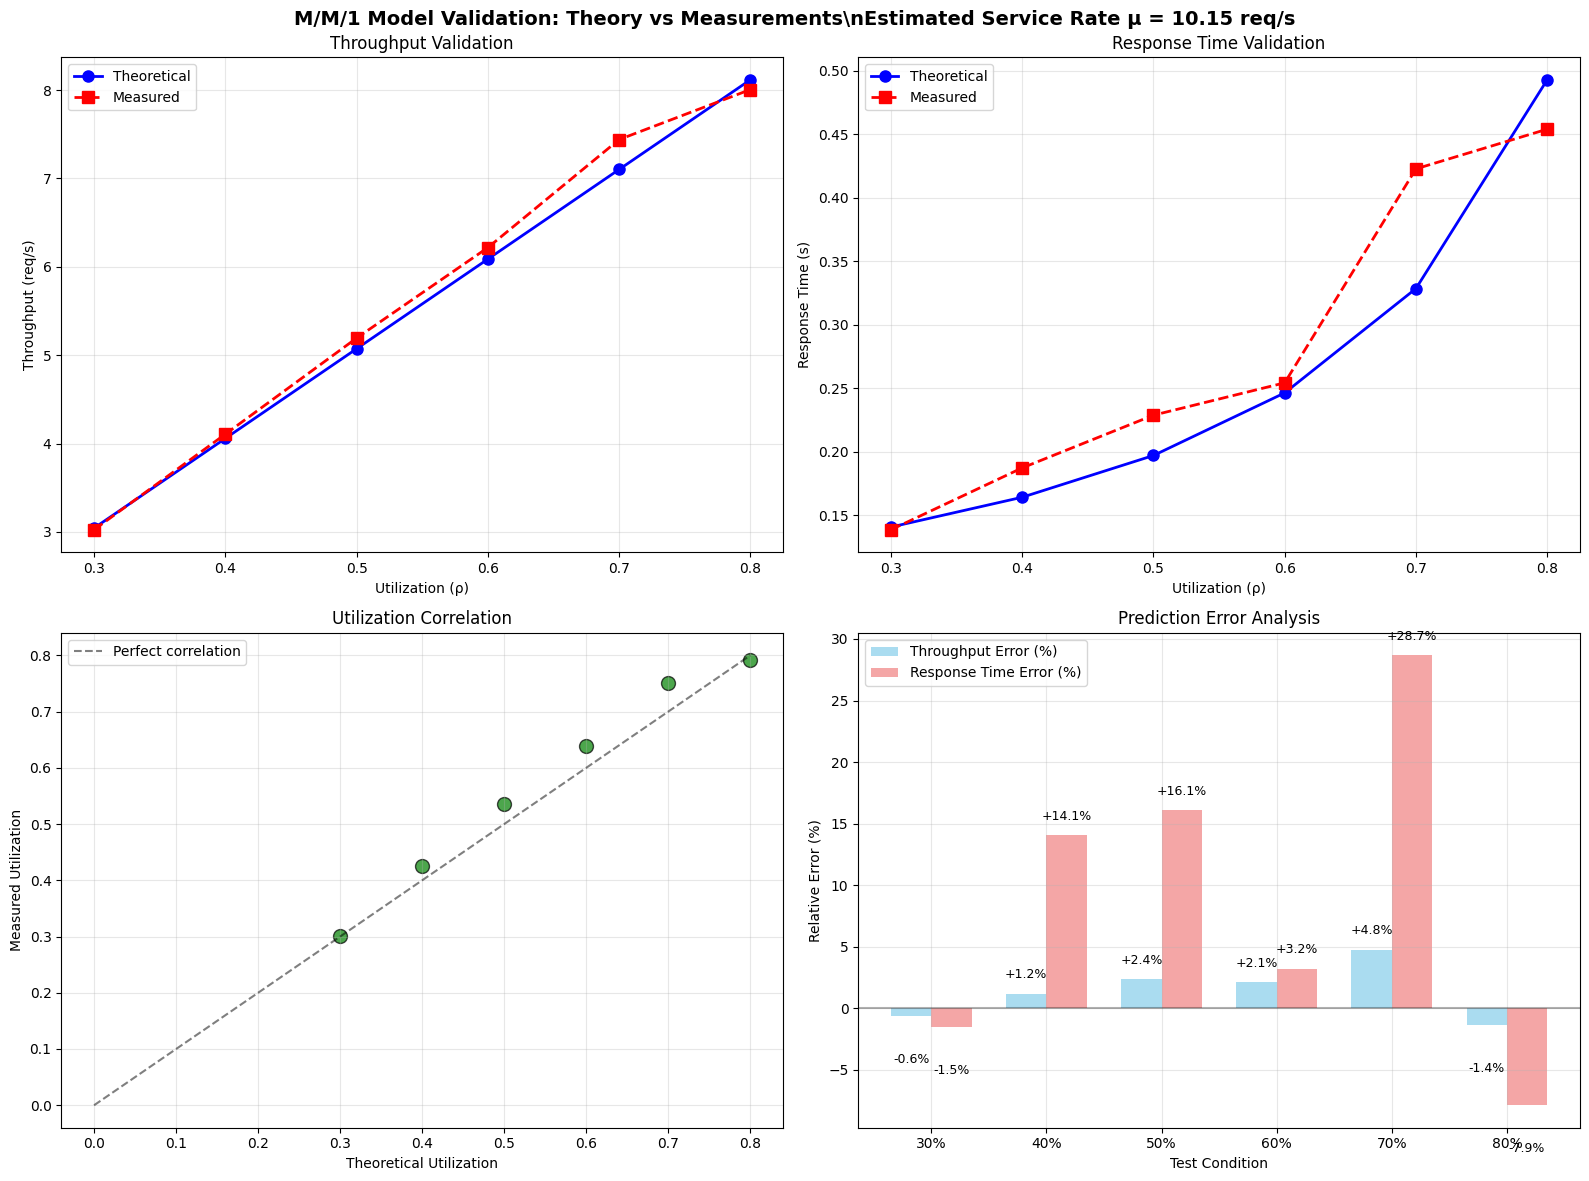


Statistical Validation Summary:
Correlation coefficients:
  Throughput: 0.997
  Response Time: 0.943
  Utilization: 0.993

Mean Absolute Relative Errors:
  Throughput: 2.1%
  Response Time: 11.9%

Overall Model Assessment:
  Model accuracy: Good
  Minimum correlation: 0.943
  Maximum error: 11.9%

Response Time Measurement Sources:
λ=3.04: server-side (Prometheus)
  Client: 0.142s, Server: 0.139s, Diff: 2.3%
λ=4.06: server-side (Prometheus)
  Client: 0.191s, Server: 0.187s, Diff: 1.7%
λ=5.07: server-side (Prometheus)
  Client: 0.233s, Server: 0.229s, Diff: 1.7%
λ=6.09: server-side (Prometheus)
  Client: 0.252s, Server: 0.254s, Diff: 1.1%
λ=7.10: server-side (Prometheus)
  Client: 0.415s, Server: 0.423s, Diff: 2.0%
λ=8.12: server-side (Prometheus)
  Client: 0.455s, Server: 0.454s, Diff: 0.1%

Response time measurement summary:
  Client-side only: 0
  Server-side only: 6
  Both available: 6


In [14]:
# =============================================================================
# VALIDATION RESULTS ANALYSIS
# =============================================================================

def analyze_validation_results(theoretical_predictions, measured_metrics, estimated_mu):
    """
    Analyze and display M/M/1 validation results.
    """
    print("M/M/1 Model Validation Analysis")
    print("=" * 35)
    
    # Create comprehensive validation plots using imported function
    plot_mm1_validation_analysis(theoretical_predictions, measured_metrics, estimated_mu)
    
    # Calculate statistical validation metrics using imported function
    stats = calculate_validation_statistics(theoretical_predictions, measured_metrics)
    
    # Display statistical analysis
    print(f"\nStatistical Validation Summary:")
    print(f"=" * 35)

    if 'error' not in stats:
        print(f"Correlation coefficients:")
        print(f"  Throughput: {stats['throughput_corr']:.3f}")
        print(f"  Response Time: {stats['response_time_corr']:.3f}")
        print(f"  Utilization: {stats['utilization_corr']:.3f}")

        print(f"\nMean Absolute Relative Errors:")
        print(f"  Throughput: {stats['throughput_mae']:.1f}%")
        print(f"  Response Time: {stats['response_time_mae']:.1f}%")

        print(f"\nOverall Model Assessment:")
        print(f"  Model accuracy: {stats['assessment']}")
        print(f"  Minimum correlation: {stats['min_correlation']:.3f}")
        print(f"  Maximum error: {stats['max_error']:.1f}%")
    else:
        print(stats['error'])
    
    # Additional response time source analysis
    print(f"\nResponse Time Measurement Sources:")
    print(f"=" * 35)
    
    client_count = 0
    server_count = 0
    both_count = 0
    
    for lambda_rate, metrics in measured_metrics.items():
        source = metrics['response_time_source']
        rt_client = metrics['response_time_client']
        rt_server = metrics['response_time_server']
        
        print(f"λ={lambda_rate:.2f}: {source}")
        
        if source == "client-side":
            client_count += 1
        elif source == "server-side (Prometheus)":
            server_count += 1
            
        if rt_client is not None and rt_server is not None:
            both_count += 1
            diff_pct = abs(rt_client - rt_server) / rt_client * 100
            print(f"  Client: {rt_client:.3f}s, Server: {rt_server:.3f}s, Diff: {diff_pct:.1f}%")
    
    print(f"\nResponse time measurement summary:")
    print(f"  Client-side only: {client_count}")
    print(f"  Server-side only: {server_count}")
    print(f"  Both available: {both_count}")

# Execute validation analysis
analyze_validation_results(theoretical_predictions, measured_metrics, estimated_mu)

## Swarm-based Stress Test: Scaling mm1-server replicas

This final section mirrors the validation but targets the Docker Swarm stack instead of the local docker-compose deployment. We keep the same Envoy entrypoint (`http://localhost:8084`) and Prometheus (`http://localhost:9090`).

Prerequisites:
- A Swarm stack deployed with `docker stack deploy -c docker-stack.yml spe`
- Service name for the M/M/1 server in Swarm is `spe_mm1-server`

What we do here:
- Optionally scale `mm1-server` replicas (e.g., 1 → 2 → 3)
- Generate an open-loop workload via Envoy (port 8084)
- Collect Prometheus metrics in parallel
- Compare measured throughput/response time across replica counts


In [ ]:
# =============================================================================
# SWARM STRESS TEST: SCALE REPLICAS AND MEASURE (CLIENT-SIDE METRICS ONLY)
# =============================================================================

import subprocess
import time
from workload_generator import AsyncWorkloadGenerator

SWARM_SERVICE_NAME = "spe_mm1-server"
REPLICA_PLAN = [1,2]     # adjust as needed
SWARM_SETTLE_SECONDS = 20    # wait after scaling for tasks to come up
TEST_DURATION = 180          # per-replica test duration (seconds)
INPUT_RATE=12

async def run_swarm_stress_test():
    print("Swarm Stress Test (Client-side metrics only)")
    print("=============================================")

    results_by_replicas = {}
    prediction_by_replicas = {}

    for replicas in REPLICA_PLAN:
        print(f"\nScaling {SWARM_SERVICE_NAME} to {replicas} replicas ...")
        try:
            subprocess.run(
                ["docker", "service", "scale", f"{SWARM_SERVICE_NAME}={replicas}"],
                check=True, capture_output=True, text=True
            )
        except subprocess.CalledProcessError as e:
            print("Failed to scale service:", e.stderr)
            raise

        print(f"Waiting {SWARM_SETTLE_SECONDS}s for Swarm to settle...")
        time.sleep(SWARM_SETTLE_SECONDS)

        generator = AsyncWorkloadGenerator(target_url="http://localhost:8084", timeout=300.0)

        print("Generating workload...")
        
        workload = await generator.generate_workload(
            lambda_rate=INPUT_RATE, 
            duration=TEST_DURATION, 
            verbose=False
        )

        # Use ONLY client-side metrics from workload generator
        measured = {
            'replicas': replicas,
            'workload_rate': workload.actual_rate,           # Client-side throughput
            'success_rate': workload.success_rate,
            'response_time_client': workload.average_response_time,  # Client-side response time
            'total_requests': workload.total_requests,
            'duration': workload.duration
        }

        results_by_replicas[replicas] = measured

        print(f"Completed replicas={replicas}: "
              f"rate={measured['workload_rate']:.2f} req/s, "
              f"rt={measured['response_time_client']:.3f}s, "
              f"success={measured['success_rate']:.1%}")

    return results_by_replicas

# Execute
swarm_results = await run_swarm_stress_test()

# Print summary
print("\n" + "="*60)
print("SWARM STRESS TEST SUMMARY (Client-side metrics)")
print("="*60)
for r, m in swarm_results.items():
    print(f"Replicas: {r}")
    print(f"  Throughput: {m['workload_rate']:.2f} req/s")
    print(f"  Response Time: {m['response_time_client']:.3f}s")
    print(f"  Success Rate: {m['success_rate']:.1%}")
    print(f"  Total Requests: {m['total_requests']}")
    print()


Swarm Stress Test (Client-side metrics only)

Scaling spe_mm1-server to 1 replicas ...
Waiting 20s for Swarm to settle...


In [13]:
# Plot Swarm scaling results
from swarm_plots import plot_swarm_scaling_results
plot_swarm_scaling_results(swarm_results)


NameError: name 'swarm_results' is not defined

In [ ]:




print(predictions)


{'throughput': 1, 'response_time': 0.75, 'stable': True}
